In [4]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import daskdataframe as dd
#import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr

In [5]:
job_extra = ["--qos=cf_lowprio",'--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--constraint=lr6_m192'] 
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=12, walltime='10:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client = Client(cluster) 
cluster.scale_up(10)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37944 instead
  warnings.warn(


In [6]:
cluster

In [3]:
directory = "/global/scratch/users/harsha/LENS/cesm2/tasmax/TREFHTMX/"
directory0 = "/global/scratch/users/harsha/LENS/cesm2/tasmax"
files  = glob.glob(directory+"b.e21.BHIST*.nc")
datelen = 20
emembers    = [f.replace(directory,"").replace("b.e21.BHIST","").replace("cam.h1.TREFHTMX.","").replace("f09_g17.LE2-","").replace("cmip6.","").replace("smbb.","") for f in glob.glob(directory+"b.e21.BHIST*.nc")] 
emembers    = [f.replace(f[-datelen:],"") for f in emembers]
emembers    = list(set(emembers))
emembers    = sorted(emembers)
#file2 = file.replace(directory,"").replace("b.e21.BHIST","").replace("cam.h1.TREFHTMX.","").replace("f09_g17.LE2-","").replace("smbb","")

In [5]:
print(emembers)

['1001.001.', '1011.001.', '1021.002.', '1031.002.', '1041.003.', '1051.003.', '1061.004.', '1071.004.', '1081.005.', '1091.005.', '1101.006.', '1111.006.', '1121.007.', '1131.007.', '1141.008.', '1151.008.', '1161.009.', '1171.009.', '1181.010.', '1191.010.', '1231.001.', '1231.002.', '1231.003.', '1231.004.', '1231.005.', '1231.006.', '1231.007.', '1231.008.', '1231.009.', '1231.010.', '1231.011.', '1231.012.', '1231.013.', '1231.014.', '1231.015.', '1231.016.', '1231.017.', '1231.018.', '1231.019.', '1231.020.', '1251.001.', '1251.002.', '1251.003.', '1251.004.', '1251.005.', '1251.006.', '1251.007.', '1251.008.', '1251.009.', '1251.010.', '1251.011.', '1251.012.', '1251.013.', '1251.014.', '1251.015.', '1251.016.', '1251.017.', '1251.018.', '1251.019.', '1251.020.', '1281.001.', '1281.002.', '1281.003.', '1281.004.', '1281.005.', '1281.006.', '1281.007.', '1281.008.', '1281.009.', '1281.010.', '1281.011.', '1281.012.', '1281.013.', '1281.014.', '1281.015.', '1281.016.', '1281.017.'

In [6]:
cmip0 = 'b.e21.BHISTcmip6.f09_g17.LE2-'
smbb0 = 'b.e21.BHISTsmbb.f09_g17.LE2-'
file1 = []
for i in range(100):
    file = glob.glob(directory+cmip0+emembers[i]+'*.nc')
    file1.append(file)
    if len(file1[i])==0:
           file1[i] = glob.glob(directory+smbb0+emembers[i]+'*.nc')
    #print(i,len(file1[i]),emembers[i])
#file1 is now a list of lists.

In [8]:
#file1[0]

In [9]:
%%time
#for file in file1[0]:
#    print(file)
ds1 = xr.open_mfdataset(file1[0],decode_times=True,decode_timedelta='True')
#ds1.chunk()   
ds1.nbytes/1e9

CPU times: user 1.26 s, sys: 113 ms, total: 1.37 s
Wall time: 1.37 s


13.486773896

In [10]:
ds1=ds1.TREFHTMX

In [11]:
ds1

<xarray.DataArray 'TREFHTMX' (time: 60226, lat: 192, lon: 288)>
dask.array<concatenate, shape=(60226, 192, 288), dtype=float32, chunksize=(3650, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Maximum reference height temperature over output period
    cell_methods:  time: maximum

In [12]:
%%time
ds1.to_zarr(directory+'test1.zarr')

CPU times: user 25.4 s, sys: 2.36 s, total: 27.7 s
Wall time: 50.9 s


In [14]:
ds2 = xr.open_zarr(directory+'test1.zarr')

In [72]:
ds1.time_written.astype('float64',copy='False')
#ds1.date_written.astype('float64')

<xarray.DataArray 'time_written' (time: 60226)>
dask.array<astype, shape=(60226,), dtype=float64, chunksize=(3650,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00

In [70]:
%%time
scratchf  = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
filename  = 'b.e21.BHIST.'
path0     = scratchf+filename+'001.nc'
comp      = dict(zlib=True, complevel=5)
encoding0 = {var: comp for var in ds1.data_vars}
ds1.time_written.astype('float64').date_written.astype('float64').to_netcdf(path0,mode='w',encoding=encoding0, engine='netcdf4') #The encoding argument is necessary because while xarray 
#does encode a dataset built from multiple netcdf files, it doesn't encode when we write the dataset back to netcdf.
#This leads huge file sizes which defeats the purpose of netcdf format.Has this been fixed in recent xarray versions?
print(path0)

AttributeError: 'DataArray' object has no attribute 'date_written'

In [90]:
%%time
scratchf  = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
filename  = 'b.e21.BHIST.'
path0     = scratchf+filename+'001.nc'
ds1_check = xr.open_mfdataset(path0,decode_times=True,drop_variables={'date_written','time_written','time_bnds'})

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.
CPU times: user 328 ms, sys: 22.2 ms, total: 350 ms
Wall time: 347 ms


In [91]:
ds1_check.TREFHTMX

<xarray.DataArray 'TREFHTMX' (time: 60226, lat: 192, lon: 288)>
dask.array<open_dataset-6758911361b35dd0539b47ed50fca7fbTREFHTMX, shape=(60226, 192, 288), dtype=float32, chunksize=(60226, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Maximum reference height temperature over output period
    cell_methods:  time: maximum

In [12]:
ds1_check.TREFHTMX

<xarray.DataArray 'TREFHTMX' (time: 60226, lat: 192, lon: 288)>
[3330256896 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Maximum reference height temperature over output period
    cell_methods:  time: maximum

In [9]:
ds1_check.chunk(chunks={'time':3650})

<xarray.Dataset>
Dimensions:       (lat: 192, lon: 288, time: 60226, lev: 32, ilev: 33, nbnd: 2)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/26)
    gw            (time, lat) float64 dask.array<chunksize=(3650, 192), meta=np.ndarray>
    hyam          (time, lev) float64 dask.array<chunksize=(3650, 32), meta=np.ndarray>
    hybm          (time, lev) float64 dask.array<chunksize=(3650, 32), meta=np.ndarray>
    P0            (time) float64 dask.array<chunksize=(3650,), meta=np.ndarray>
    hyai          (time, ilev) float64 dask.array<chunksize=(3650, 33), meta=np.ndarray>
    hybi          (time, ilev) float64 dask.array<chunksize=(3650, 33), meta=np.ndarray>
    ...            ...
    n2ovmr        (time) float64 dask.array<chunksize=(3650,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(3650,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(3650,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(3650,), meta=np.ndarray>
    nsteph        (time) float64 dask.array<chunksize=(3650,), meta=np.ndarray>
    TREFHTMX      (time, lat, lon) float32 dask.array<chunksize=(3650, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BHISTcmip6.f09_g17.LE2-1001.001
    logname:           sunseon
    host:              mom1
    initial_file:      b.e21.B1850.f09_g17.CMIP6-piControl.001.cam.i.1001-01-...
    topography_file:   /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/fv_0.9x...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  day_1

In [11]:
tmax = ds1_check.TREFHTMX.isel(lat=10,lon=15)
tmax

<xarray.DataArray 'TREFHTMX' (time: 60226, lat: 192, lon: 288)>
[3330256896 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Maximum reference height temperature over output period
    cell_methods:  time: maximum

In [26]:
#datetimeindex = ds1.indexes['time'].to_datetimeindex()

/tmp/ipykernel_33810/1909999924.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = ds1.indexes['time'].to_datetimeindex()


In [29]:
date

<xarray.DataArray 'date' (time: 60226)>
array([18500101., 18500102., 18500103., ..., 20141230., 20141231., 20150101.])
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2015-01-01 00:00:00
Attributes:
    long_name:  current date (YYYYMMDD)

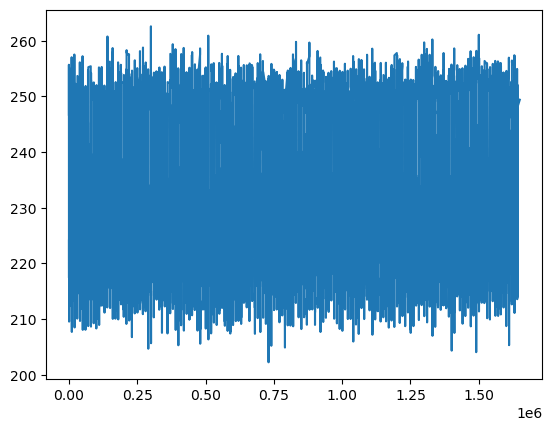

In [30]:
plt.plot(date-18500101,tmax)

In [1]:
%%time 
#ds = xr.open_mfdataset(directory+"b.e21.BSSP370smbb.f09_g17.LE2-1301.01[6-9].cam.h1.TREFHTMX.20150101-20241231.nc",
#                  concat_dim="new", combine="nested")
ds_hist = xr.open_mfdataset(directory+"b.e21.BHIST*.nc",
                concat_dim="member", combine="nested")   

NameError: name 'xr' is not defined

In [ ]:
%%time
mean0= ds.TREFHTMX.mean("member")

In [ ]:
%%time
mean0.to_netcdf('test.nc')

In [ ]:
result = xr.open_dataset('test.nc')

In [22]:
result.nbytes/1e9

0.80735464

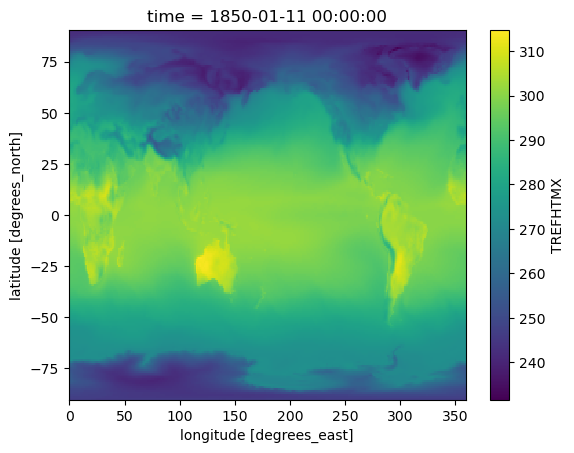

In [19]:
result.TREFHTMX.isel(time=10).plot()

In [7]:
ds.TREFHTMX

,Array,Chunk
Bytes,75.19 GiB,769.92 MiB
Shape,"(100, 3650, 192, 288)","(1, 3650, 192, 288)"
Count,400 Tasks,100 Chunks
Type,float32,numpy.ndarray


In [19]:
mem_list = np.arange(10)
tmax1 = ds.TREFHTMX.isel(member=mem_list)

In [20]:
tmax1

<xarray.DataArray 'TREFHTMX' (member: 10, time: 3650, lat: 192, lon: 288)>
dask.array<getitem, shape=(10, 3650, 192, 288), dtype=float32, chunksize=(1, 3650, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-01-01 00:00:00 ... 1859-12-31 00:00:00
Dimensions without coordinates: member
Attributes:
    units:         K
    long_name:     Maximum reference height temperature over output period
    cell_methods:  time: maximum

In [26]:
%%time 
mean1 = tmax1.mean("member")

CPU times: user 6.02 ms, sys: 781 µs, total: 6.8 ms
Wall time: 6.63 ms


In [27]:
%%time
mean1.compute()

CPU times: user 3.15 s, sys: 1.89 s, total: 5.03 s
Wall time: 39 s


<xarray.DataArray 'TREFHTMX' (time: 3650, lat: 192, lon: 288)>
array([[[247.423  , 247.423  , 247.423  , ..., 247.423  , 247.423  ,
         247.423  ],
        [248.39624, 248.36565, 248.20345, ..., 248.40076, 248.40015,
         248.4089 ],
        [248.92831, 248.9021 , 248.89229, ..., 249.11038, 249.07735,
         249.02385],
        ...,
        [240.19243, 240.21887, 240.24637, ..., 240.12283, 240.14542,
         240.16821],
        [240.30774, 240.3123 , 240.31718, ..., 240.29373, 240.29756,
         240.30269],
        [240.10986, 240.11076, 240.11157, ..., 240.10666, 240.10786,
         240.10892]],

       [[248.30728, 248.30728, 248.30728, ..., 248.30728, 248.30728,
         248.30728],
        [249.1998 , 249.16634, 249.00175, ..., 249.2268 , 249.21423,
         249.20625],
        [249.80273, 249.7531 , 249.72197, ..., 250.06747, 250.00008,
         249.92343],
...
        [254.25003, 254.2806 , 254.30594, ..., 254.1646 , 254.19678,
         254.22372],
        [252.11914, 252.14957, 252.18152, ..., 252.00552, 252.0458 ,
         252.08443],
        [250.22713, 250.23222, 250.23691, ..., 250.20865, 250.21542,
         250.22159]],

       [[248.29924, 248.29924, 248.29924, ..., 248.29924, 248.29924,
         248.29924],
        [248.89453, 248.85632, 248.69707, ..., 248.9209 , 248.9134 ,
         248.90451],
        [249.18057, 249.14775, 249.13028, ..., 249.43188, 249.37065,
         249.29475],
        ...,
        [254.06877, 254.05888, 254.04599, ..., 254.09262, 254.08769,
         254.07858],
        [252.58199, 252.5811 , 252.5784 , ..., 252.57104, 252.57614,
         252.58008],
        [251.36409, 251.3676 , 251.3708 , ..., 251.35112, 251.35588,
         251.36015]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-01-01 00:00:00 ... 1859-12-31 00:00:00

In [31]:
mean1.indexes['time'].to_datetimeindex()

/tmp/ipykernel_40260/3078645660.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  mean1.indexes['time'].to_datetimeindex()


DatetimeIndex(['1850-01-01', '1850-01-02', '1850-01-03', '1850-01-04',
               '1850-01-05', '1850-01-06', '1850-01-07', '1850-01-08',
               '1850-01-09', '1850-01-10',
               ...
               '1859-12-22', '1859-12-23', '1859-12-24', '1859-12-25',
               '1859-12-26', '1859-12-27', '1859-12-28', '1859-12-29',
               '1859-12-30', '1859-12-31'],
              dtype='datetime64[ns]', length=3650, freq=None)

ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

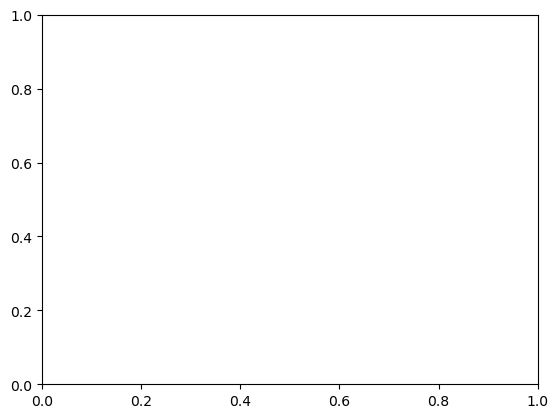

In [34]:
mean1.isel(lat=10,lon=100).plot()